In [2]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
from skimage.transform import resize
import math


In [75]:
img_dir = "./data/downloaded/ericcahan/Alamar, Ciudad De La Habana, Cuba - Sunset 8:11pm.jpg"

In [76]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    r, g, b = np.array(image).reshape(-1, n_dims).T
    # return pd.DataFrame({'r': r, 'g': g, 'b': b}).sample(n=sample_size)
    return pd.DataFrame({'r': r, 'g': g, 'b': b})
    

(2250, 1800, 3)


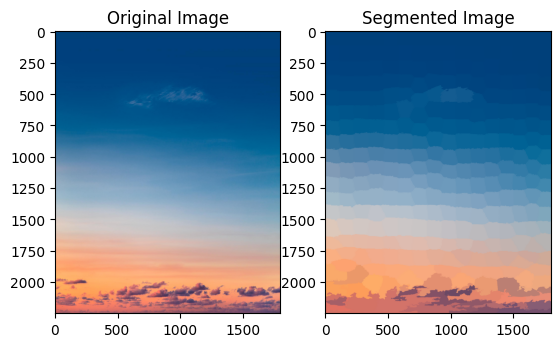

In [77]:
from skimage.io import imread, imsave
from skimage.segmentation import slic
from skimage.color import label2rgb
import matplotlib.pyplot as plt

# Load and preprocess the image
image = imread(img_dir)

# Apply SLIC algorithm
num_segments = 300  # You can adjust this value
compactness = 10    # You can adjust this value
segments = slic(image, n_segments=num_segments, compactness=compactness)

# Visualize the superpixels
segmented_image = label2rgb(segments, image, kind='avg')

# Display the result
plt.subplot(1, 2, 1)
plt.imshow(image)
print(image.shape)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")

plt.show()

# Save the segmented image
imsave("segmented_image.jpg", segmented_image)

In [78]:
from skimage.measure import regionprops

# Get the region properties of each segment
segment_props = regionprops(segments)


segment_info = []
for label, props in enumerate(segment_props):
    cluster_mask = segments == (label + 1)  # +1 because segment labels are 1-based
    cluster_pixels = image[cluster_mask]
    
    if len(cluster_pixels) > 0:
        mean_color = np.mean(cluster_pixels, axis=0)
        centroid = props.centroid
        points = props.coords.tolist()  # Convert to list for JSON serialization
        centroid_row, centroid_col = map(int, props.centroid)
        
        segment_dict = {
            'label': label + 1,
            'row_index': centroid_row,
            'col_index': centroid_col,
            'mean_color': mean_color.tolist(),
            'points': points
        }
        
        segment_info.append(segment_dict)

# Convert the array of dictionaries to a NumPy array
segment_info_array = np.array(segment_info, dtype=object)


# mean_colors = []
# # Display the pixel indices of the cluster centroids
# for label, props in enumerate(segment_props):
#     cluster_mask = segments == (label+1)
#     centroid_row, centroid_col = map(int, props.centroid)
#     cluster_image = image.copy()
#     cluster_image[~cluster_mask] = 0

#     mean_color = cluster_image[cluster_mask].mean(axis=0)
#     mean_colors.append(mean_color)
#     print(f"Cluster {label} Centroid Pixel Index: Row {centroid_row}, Column {centroid_col}")

# Plot the mean colors

print(segment_info_array[-1]['points'])


[[2179, 1281], [2179, 1282], [2179, 1283], [2179, 1284], [2179, 1285], [2179, 1286], [2180, 1280], [2180, 1281], [2180, 1282], [2180, 1283], [2180, 1284], [2180, 1285], [2180, 1286], [2180, 1287], [2180, 1288], [2181, 1280], [2181, 1281], [2181, 1282], [2181, 1283], [2181, 1284], [2181, 1285], [2181, 1286], [2181, 1287], [2181, 1288], [2182, 1280], [2182, 1281], [2182, 1282], [2182, 1283], [2182, 1284], [2182, 1285], [2182, 1286], [2182, 1287], [2182, 1288], [2182, 1289], [2183, 1280], [2183, 1281], [2183, 1282], [2183, 1283], [2183, 1284], [2183, 1285], [2183, 1286], [2183, 1287], [2183, 1288], [2183, 1289], [2183, 1290], [2184, 1280], [2184, 1281], [2184, 1282], [2184, 1283], [2184, 1284], [2184, 1285], [2184, 1286], [2184, 1287], [2184, 1288], [2184, 1289], [2184, 1290], [2185, 1280], [2185, 1281], [2185, 1282], [2185, 1283], [2185, 1284], [2185, 1285], [2185, 1286], [2185, 1287], [2185, 1288], [2185, 1289], [2185, 1290], [2186, 1279], [2186, 1280], [2186, 1281], [2186, 1282], [2186

[  0.18937058  65.97969595 125.14764827]
[  6.18921808  89.21989505 142.40422371]
[ 93.2181192  144.00902086 179.66602998]
[193.542207   183.38299363 182.63326043]
[215.78191352 143.60793855 119.52720541]


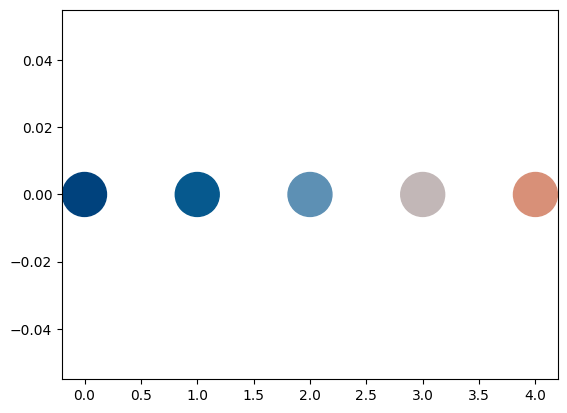

In [92]:
num_colors = 5

top_row_index = 0
bottom_row_index = segment_info_array[-1]['points'][-1][0]



stop_row_indices = np.linspace(top_row_index, bottom_row_index, num_colors + 1, dtype=int)

key_colors = []
for i in range(stop_row_indices.astype(int).shape[0]):
    if i == 0:
        continue
    else:
        start_row_index = stop_row_indices[i-1].astype(int)
        stop_row_index = stop_row_indices[i].astype(int)
        filtered_segment_info_array = np.array([d for d in segment_info_array if d['row_index'] >= start_row_index and d['row_index'] <= stop_row_index])
        mean_colors = np.array([d['mean_color'] for d in filtered_segment_info_array])
        mean_color = np.mean(mean_colors, axis=0)
        print(mean_color)
        key_colors.append(mean_color)

key_colors = np.array(key_colors)
plt.scatter(np.arange(len(key_colors)), np.zeros(len(key_colors)), c=key_colors/255.0, s=1000)

In [93]:
def create_color_gradient_key_colors(key_colors, gradient_width, gradient_height):
    # gradient_colors = calculate_intermediate_colors(key_colors, len(key_colors))
    gradient_colors = [tuple(color) for color in key_colors.astype(int)]
    
    gradient_palette = Image.new("RGB", (gradient_width, gradient_height))
    draw = ImageDraw.Draw(gradient_palette)
    
    color_width = gradient_width / len(gradient_colors)
    for i, color in enumerate(gradient_colors):
        draw.rectangle([(i * color_width, 0), ((i + 1) * color_width, gradient_height)], fill=color)
    
    return gradient_palette


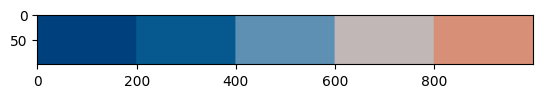

In [94]:
gradient_image = create_color_gradient_key_colors(key_colors, 1000, 100)
plt.imshow(gradient_image)
gradient_image.show()